In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint, solve_ivp

In [19]:
class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model
    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u
    """
    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq
       
    def _reaction(self, y):
        """
        Compute the reaction term in real space
        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]   # first get u from y then get v from y
        u_dot = -u*(v**2) + self.b * (1 - u)   # reaction term in real space w/ u
        v_dot = u*(v**2) - self.kappa * v      # reaction term in real space w/ v
        return np.hstack([u_dot, v_dot])       # stack terms to return vector

    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        y = np.reshape(y, (self.nx, self.ny))   # reshape y to have size nx by ny
        yk = np.fft.fft2(y)                     # Fourier Transform
        lap = -self.ksq * yk                    # laplace step
        lap = np.fft.ifft2(lap)                 # inverse fourier of laplace
        return np.real(lap).flatten()           # take real components in real space and flatten to vector

    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space
        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u, v = y[:(self.ny * self.nx)], y[-(self.ny * self.nx):]   # first get u from y then get v from y
        lap_u = self._laplace(u)           # laplace of u
        lap_v = self._laplace(v)           # laplace of v
        u_out = self.du * lap_u            # diffusion coeff u * laplace u
        v_out = self.dv * lap_v            # diffusion coeff v * laplace v
        return np.hstack([u_out, v_out])   # stack terms to return vector
        
    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        return self._reaction(y) + self._diffusion(y)   # implement functions we created above

    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver
        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp
        """
        u0, v0 = y0   # set initial condition
        time = np.linspace(t_min, t_max, nt)   # define time array from t_min to t_max filled with nt points
        y0 = np.hstack([u0.flatten(), v0.flatten()])  # initial conditions to feed to solve_ivp
        solve = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=time, **kwargs)
        # solve right-hand-side from t_min to t_max with the initial state y0 (as a vector cause flatten())
        # store the solution at the time points time
        tpts =  solve.t # store the time points as tpts
        sol = solve.y   # store the values of solution
        sol = sol.T     # transpose sol
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]  # assign values of u and v from solution
        u = np.reshape(u, (nt, self.ny, self.nx))   # reshape u to grid size throughout time points nt
        v = np.reshape(v, (nt, self.ny, self.nx))   # reshape v to grid size throughout time points nt
        return tpts, np.stack([u, v], axis=-1)      # return time points and u,v solution through time

Imaginary residual is: 0.0


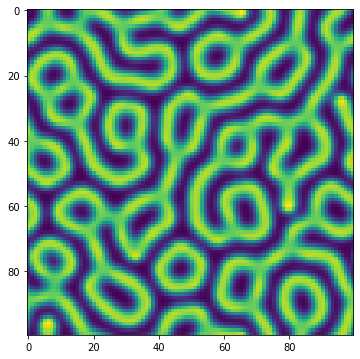

In [20]:
## Create initial conditions
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

In [14]:
a = np.array([0,1,2,3,4,5])
b = np.array([5,4,3,2,1,0])

print(np.hstack([a,b]))
print()
print(np.vstack([a,b]))

[0 1 2 3 4 5 5 4 3 2 1 0]

[[0 1 2 3 4 5]
 [5 4 3 2 1 0]]


In [15]:
np.stack([a, b], axis=-1)

array([[0, 5],
       [1, 4],
       [2, 3],
       [3, 2],
       [4, 1],
       [5, 0]])